In [45]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.signal import find_peaks

In [46]:
data = np.loadtxt("/tmp/adc_data.csv") * 1000000# reading in volts

print('n:{:>19d}'.format(len(data)))
print('median: {: .6e}'.format(np.median(data)))
print('mean:   {: .6e}'.format(np.mean(data)))
print('max:    {: .6e}'.format(np.max(data)))
print('min:    {: .6e}'.format(np.min(data)))
print('std:    {: .6e}'.format(np.std(data)))
print('p2p:    {: .6e}'.format(np.max(data)-np.min(data)))

n:              24563
median:  4.629493e+04
mean:    4.629529e+04
max:     4.639805e+04
min:     4.620374e+04
std:     2.480722e+01
p2p:     1.943110e+02


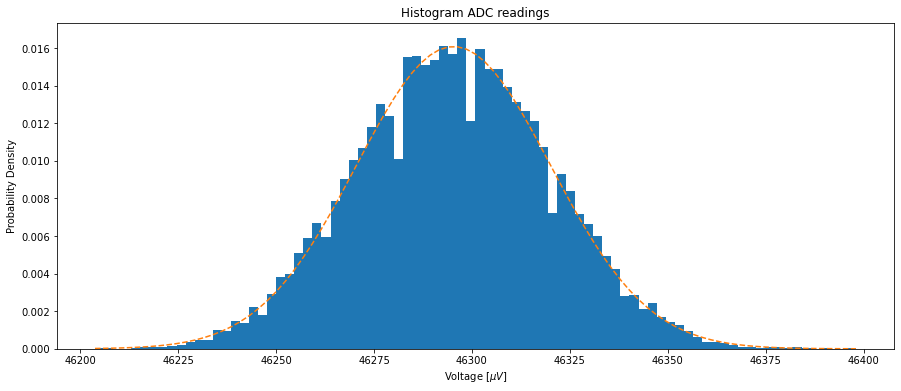

In [47]:
fig, axis = plt.subplots(figsize =(15, 6), facecolor=(1,1,1))

sigma = np.std(data)
mu = np.mean(data)

n, bins, patches = axis.hist(data, bins='fd', density=True)
# add a 'best fit' line
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
axis.plot(bins, y, '--')
axis.set_ylabel('Probability Density')
axis.set_xlabel('Voltage [$\mu V$]')
#axis.set_xlabel('Voltage [mV]')
#axis.set_xlabel('Voltage [V]')
axis.set_title(r'Histogram ADC readings')
#plt.grid()
plt.savefig('histogram.png', bbox_inches='tight')
plt.show()

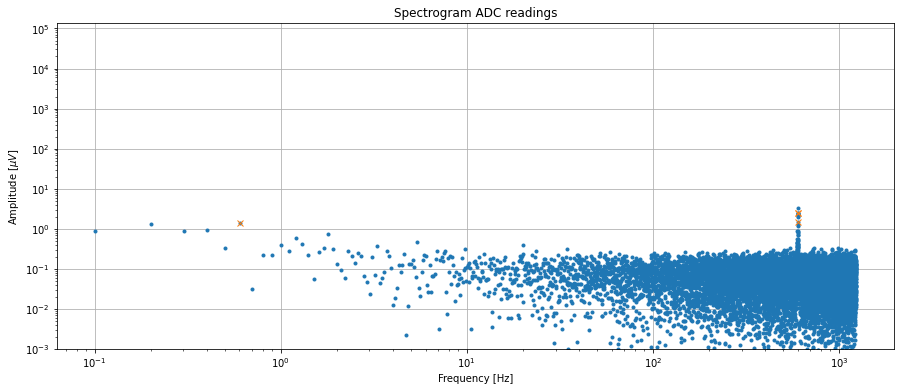

In [48]:
n = data.size
drate = 2463 # fill in the sample rate reported by the rpi_adc_stream command
timestep = 1./drate
freqbins = np.fft.rfftfreq(n, d=timestep)
fourier = np.fft.rfft(data, norm='forward')

peaks, _ = find_peaks(fourier.real, height=1.0)
peaks.resize(peaks.size+1)
peaks.sort()


fig, axis = plt.subplots(figsize =(15, 6), facecolor=(1,1,1))
#plt.plot(freqbins,20*np.log10(np.abs(fourier.real)), '.')
axis.loglog(freqbins, np.abs(fourier.real), '.')
axis.loglog(freqbins[peaks], np.abs(fourier.real[peaks]), 'x' )
axis.set_xlabel('Frequency [Hz]')
axis.set_ylabel('Amplitude [$\mu V$]')
axis.set_title(r'Spectrogram ADC readings')
plt.ylim(1e-3,)
#plt.xlim(1150,1250)
plt.grid()
plt.savefig('spectrogram.png', bbox_inches='tight') 
plt.show()

In [49]:
print('Peaks:\n')
print(' Freq. [Hz] |  Ampl. [uV] ')
print(' -----------|------------ ')
for i in peaks:
    print('{: .3e}'.format(freqbins[i]),' |','{: .3e}'.format(np.abs(fourier.real[i])))


Peaks:

 Freq. [Hz] |  Ampl. [uV] 
 -----------|------------ 
 0.000e+00  |  4.630e+04
 6.016e-01  |  1.383e+00
 5.992e+02  |  1.467e+00
 5.997e+02  |  2.462e+00
 6.001e+02  |  2.450e+00
